## **Proyecto 1 - Análisis de variables**

Stefanie M. Alvarez Pérez, 20002045

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [301]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Cargamos Dataset

In [302]:
data = pd.read_csv('/content/drive/MyDrive/Product Development/Proyecto 1/hotel_bookings.csv')

print(str(data.shape) + '\n')

data.head()

(119390, 32)



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


#### Eliminamos las columnas "Agent" y "company", son solo ID's por lo que no son relevantes.

In [303]:
data.drop('agent', axis=1, inplace=True)
data.drop('company', axis=1, inplace=True)

print(str(data.shape)) #Para revisar que sí borraron las columnas

(119390, 30)


In [304]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Análisis de Datos para toma de decisiones

##### Análisis de las variables


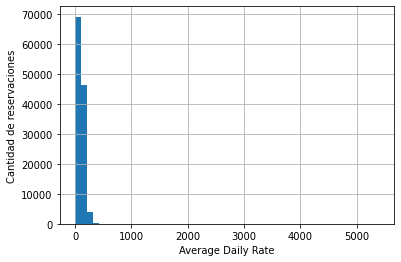

In [305]:
data['adr'].hist(bins=50, density=False) #Hacer un histograma
plt.xlabel("Average Daily Rate")
plt.ylabel("Cantidad de reservaciones")
plt.show()

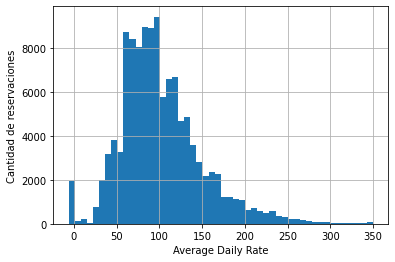

In [306]:
#transformación con transformación Box cut
np.clip(data['adr'],-100,350).hist(bins=50, density=False)
plt.xlabel("Average Daily Rate")
plt.ylabel("Cantidad de reservaciones")
plt.show()

#### 2.2 Verificamos tipos de variables en X

In [307]:
data.dtypes #(object (0) = string/categóricas)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list              

In [308]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O'] #O = tipo object

#Agregamos el caso especial de "Is_Canceled" y de "Is_repeated_guest," ya que por definición, estas variables son categóricas. Hay veces que la columna puede contener un número pero ser una variable categórica
cat_vars = cat_vars + ['is_canceled', 'is_repeated_guest'] #Lista + lista.

In [309]:
#cantidad de variables categóricas
len(cat_vars)

14

In [310]:
#Forzamos a todas las variables como categóricas
data[cat_vars] = data[cat_vars].astype('O')

In [311]:
data.dtypes #(object (0) = string/categóricas)

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list              

In [312]:
#variables numéricas (son las que no son categoricas y tampoco la variable que queremos predecir)
num_vars = [var for var in data.columns if(var not in cat_vars and var != 'survived')] #El != es para que no tome el target.

In [313]:
len(num_vars) #Con esto comprobamos que hay exactamente 18 variables numéricas y 14 categóricas

16

#### 2.3 Análisis de Valores Faltantes

In [314]:
#% de pérdidas e impacto de variables faltantes... 3 variables con na's en algún punto
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
len(var_with_na)

2

In [315]:
#proporcion de NAs en cada variable (is null mapea los nulos, ascending = los ordena de mayor a menor)
data[var_with_na].isnull().mean().sort_values(ascending=False)

country     0.004087
children    0.000034
dtype: float64

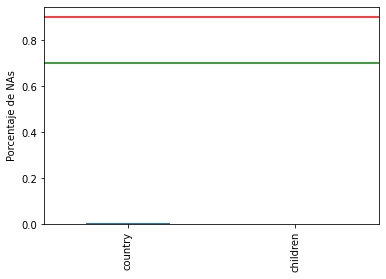

In [316]:
#graficamos porcentajes de NAs.
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel("Porcentaje de NAs")
plt.axhline(y=0.9, color="r")
plt.axhline(y=0.7, color="g") #Lo que está abajo del 0.7 es rescatable, lo que está arriba ya no

Verificar si son variables numéricas o categóricas

In [317]:
#variables categóricas con NAs. (Con las variables categóricas se hace una imputación de la categoría faltante o algo más... depende de la proporción)
cat_na = [var for var in cat_vars if var in var_with_na]
cat_na

['country']

In [318]:
#variables numéricas con NAs. (Con estas variables es que se hace imputación con media, moda, mediana, etc.)
num_na = [var for var in num_vars if var in var_with_na]
num_na

['children']

In [319]:
print("Cantidad de variables numéricas con NAs. {}".format(len(num_na)))
print("Cantidad de variables categóticas con NAs. {}".format(len(cat_na)))

#Esto suma el 2 obtenido anteriormente

Cantidad de variables numéricas con NAs. 1
Cantidad de variables categóticas con NAs. 1


#### 2.3.1 Verificación del impacto del NA

In [320]:
def na_impact_over_target(df, Xvar, Yvar):
    df = data.copy() #Le vamos a caer encima con nuevos valores
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0) #Si es nulo = 1, si no es nulo = 0
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std']) #Cuál es la media de cuando hay un valor faltante?
    
    temp.plot(kind="barh", y="mean", xerr="std", legend=False, title=Yvar)
    plt.show()

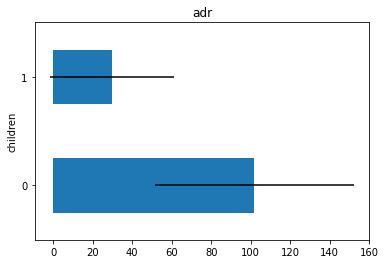

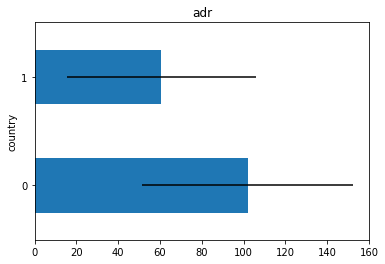

In [321]:
for var in var_with_na:
    na_impact_over_target(data, var, 'adr') #Para graficar todas las variables.

In [322]:
data.dtypes

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list              

In [323]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O'] #O = tipo object

In [324]:
len(cat_vars)

14

#### 2.4 Análisis de Variables Temporales (Variable Age)

In [325]:
year_vars = [var for var in num_vars if ('reservation_status_date' in var)]
year_vars

[]

In [326]:
#Valores distintos por variable temporal
for var in year_vars:
    print(var, data[var].unique())
    print('\n')

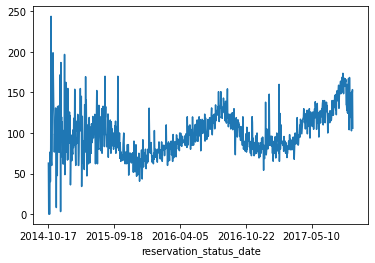

In [327]:
#Cómo la edad impacta sobre la variable a predecir? (X)[Y]
data.groupby('reservation_status_date')['adr'].median().plot()

In [328]:
def plot_target_vrs_timeVar(df, Xvar, Yvar): #Lo anterior convirtiéndolo en función
    df = df.copy() #Hacer una copia del dataset original
    df.groupby(Xvar)[Yvar].median().plot()
    plt.show()

In [329]:
for var in year_vars:
    plot_target_vrs_timeVar(data, var, 'arrival_date_week_number')

plt.show()

## 2.5 Variables Discretas


In [330]:
#Si la cantidad de elementos que tiene una variable es menor a 20, es discreta. Si es mayor, es continua
discrete_vars = [var for var in num_vars if((len(data[var].unique()) < 20) and (var not in year_vars))]
discrete_vars

['arrival_date_year',
 'stays_in_weekend_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [331]:
print("Cantidad de Variables Discretas: ", len(discrete_vars))

Cantidad de Variables Discretas:  8


In [332]:
#Podemos ver que son valores que tienen una naturaleza discreta
data[discrete_vars].head()

,arrival_date_year,stays_in_weekend_nights,adults,children,babies,previous_cancellations,required_car_parking_spaces,total_of_special_requests
0,2015,0,2,0.0,0,0,0,0
1,2015,0,2,0.0,0,0,0,0
2,2015,0,1,0.0,0,0,0,0
3,2015,0,1,0.0,0,0,0,0
4,2015,0,2,0.0,0,0,0,1


In [333]:
import seaborn as sns

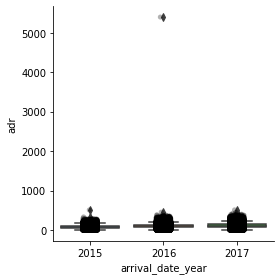

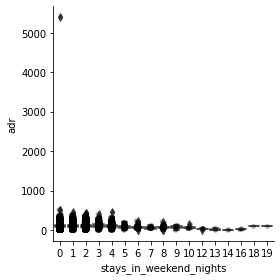

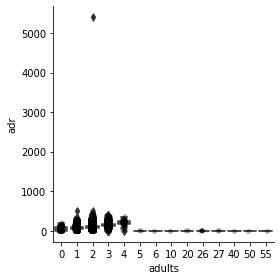

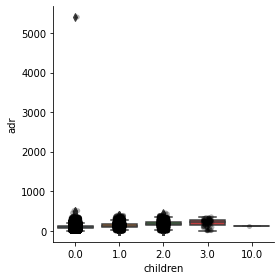

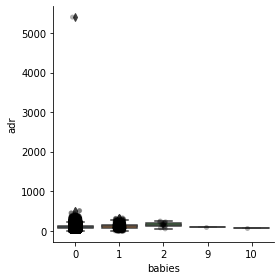

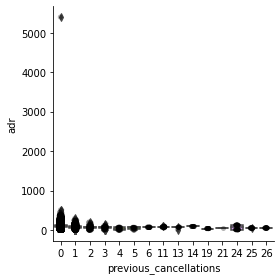

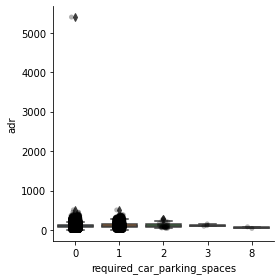

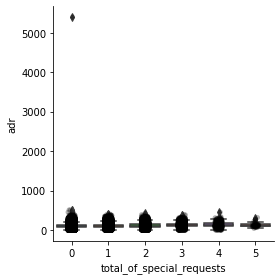

In [334]:
for var in discrete_vars:
    sns.catplot(x=var, y = 'adr', data=data, kind="box", height=4)
    sns.stripplot(x=var, y='adr', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

## 2.6 Variables Continuas

In [335]:
cont_vars = [var for var in num_vars if var not in discrete_vars + year_vars] #todas las variables no incluidas anteriormente

In [336]:
print("Variables Numericas Continuas: ", len(cont_vars))

Variables Numericas Continuas:  8


In [337]:
data[cont_vars].head() #Tiene estructura de variables continuas (con decimales, más cantidad, etc.)

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
0,342,27,1,0,0,3,0,0.0
1,737,27,1,0,0,4,0,0.0
2,7,27,1,1,0,0,0,75.0
3,13,27,1,1,0,0,0,75.0
4,14,27,1,2,0,0,0,98.0


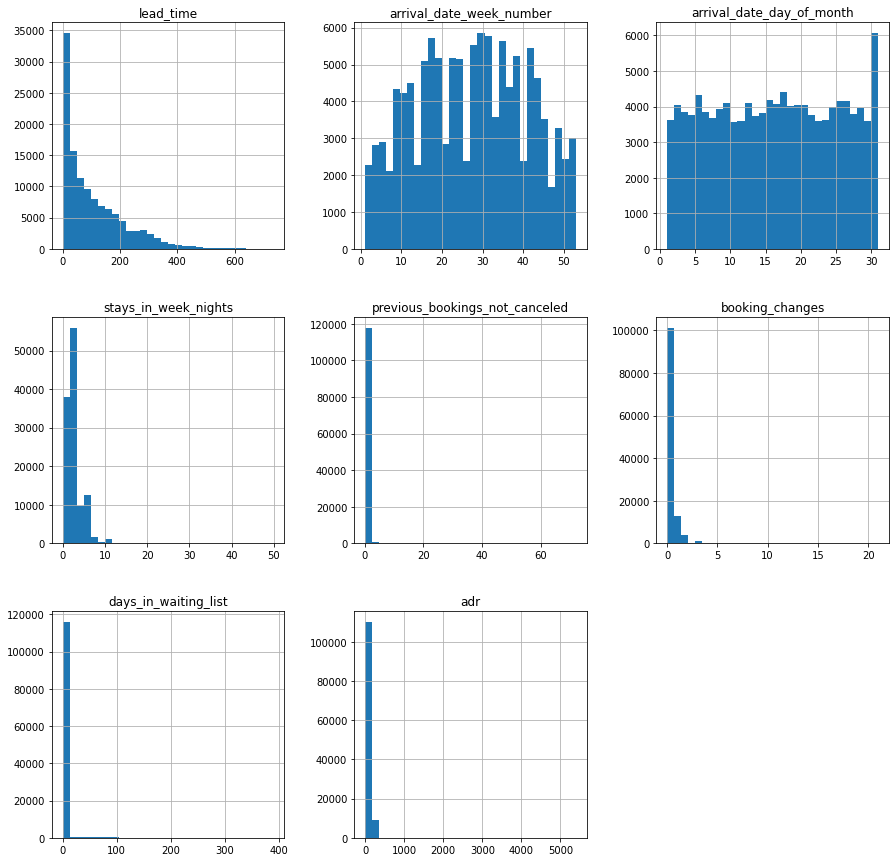

In [338]:
#Tipos de distribución que tiene, para saber qué cambios hacerle... Tener una distribución lo más normal posible
data[cont_vars].hist(bins=30, figsize=(15, 15))
plt.show()

In [339]:
#Estas son las variables que están super sesgadas
sesgadas = ['stays_in_week_nights', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr']

In [340]:
#Se quitan las que están demasiado sesgadas
cont_vars = [var for var in cont_vars if var not in sesgadas]

In [341]:
cont_vars

['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month']

#### Transformación de Yeo-Johnson

In [342]:
#Paquete para poder usar la transformación de Yeo-Johnson
import scipy.stats as stats

In [343]:
#Copia del dataset original
temp_yj = data.copy()

In [344]:
#Función de Yeo-Johnson
for var in cont_vars:
    temp_yj[var], param = stats.yeojohnson(data[var])

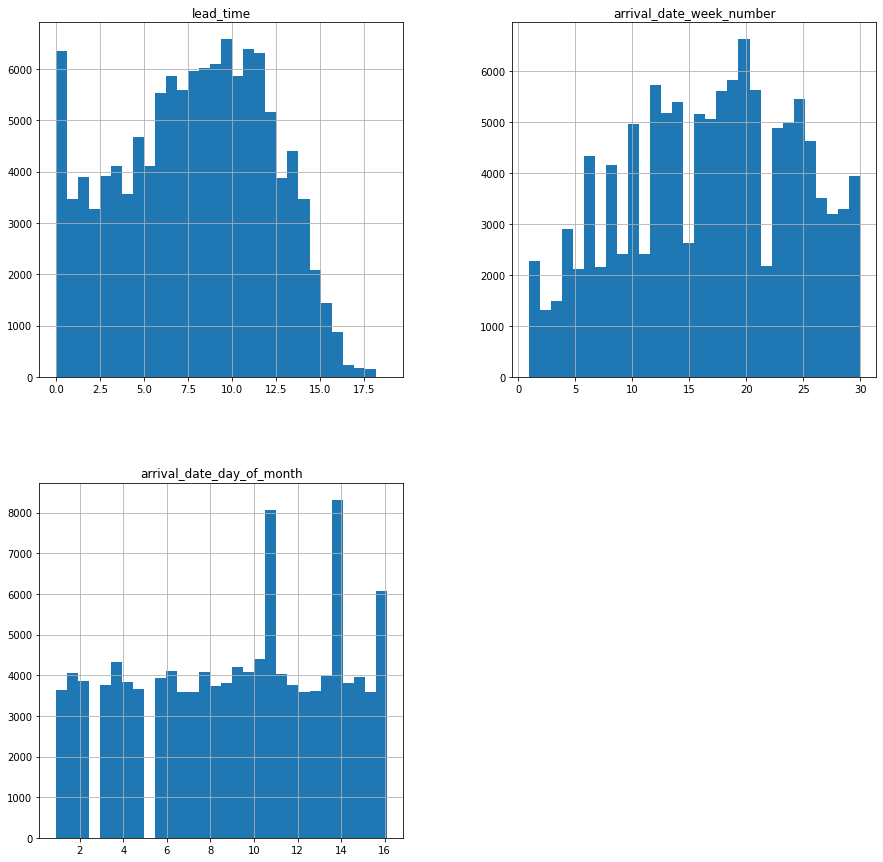

In [345]:
temp_yj[cont_vars].hist(bins=30, figsize=(15, 15))
plt.show()

In [346]:
len(cont_vars)

3

In [347]:
#cont_specials = ['Fare']

In [348]:
#Aplicar transformación logarítmica para ver si mejora la distribución
# Volver a duplicar el dataset
temp = data.copy()

for var in cont_vars:
    temp[var] = np.log(data[var] + 1)

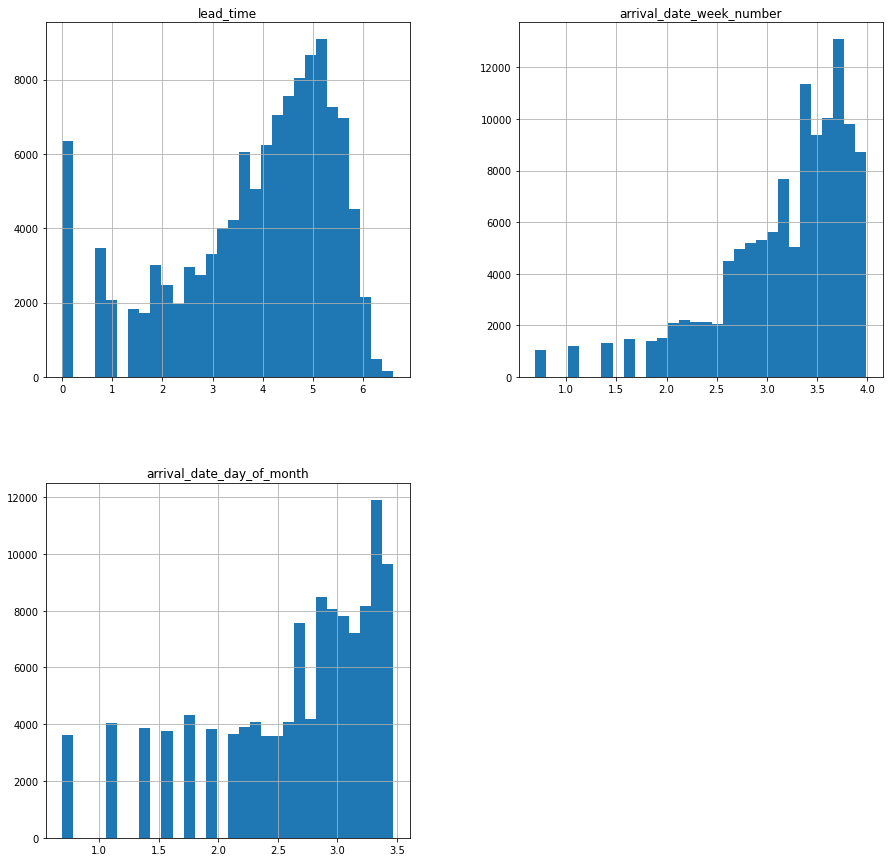

In [349]:
temp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


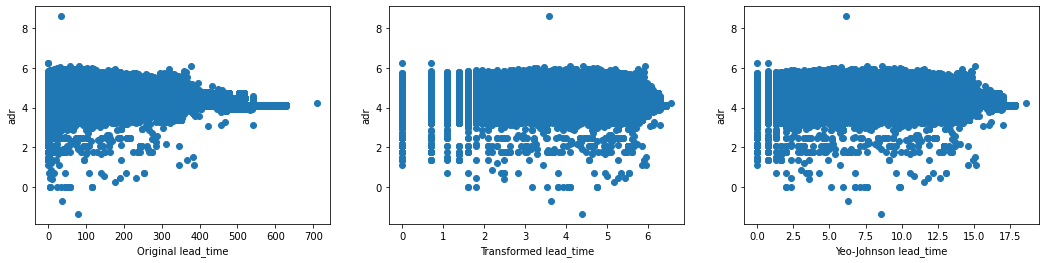

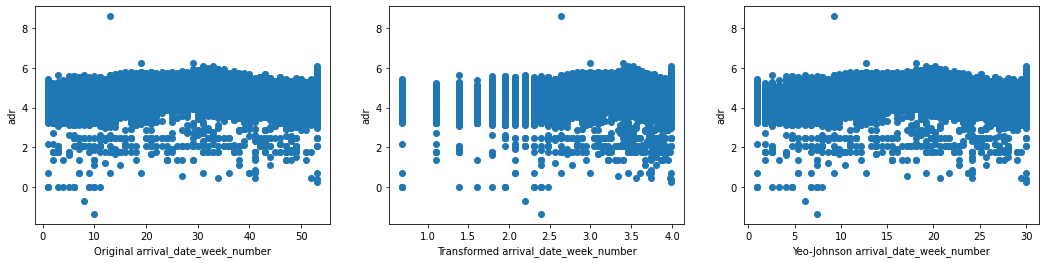

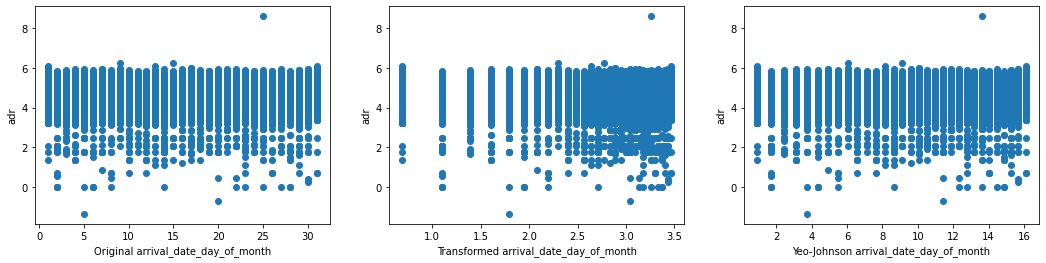

In [350]:
#Cómo impacta la transformación
for var in cont_vars:
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data[var], np.log(data['adr']))
    plt.ylabel("adr")
    plt.xlabel("Original " + var)
    
    plt.subplot(1, 3, 2)
    plt.scatter(temp[var], np.log(data['adr']))
    plt.ylabel("adr")
    plt.xlabel("Transformed " + var)
    
    plt.subplot(1, 3, 3)
    plt.scatter(temp_yj[var], np.log(data['adr']))
    plt.ylabel("adr")
    plt.xlabel("Yeo-Johnson " + var)

    plt.show()

### 2.6.1 Variables con Sesgo

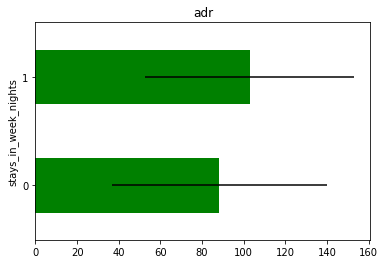

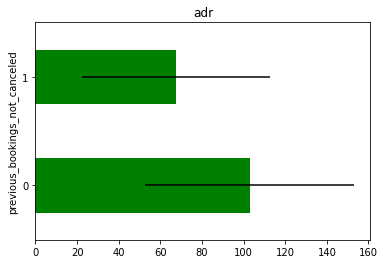

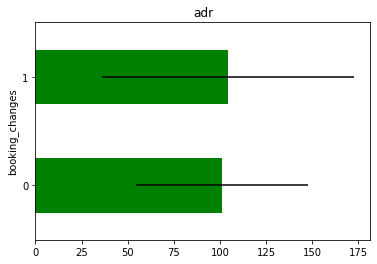

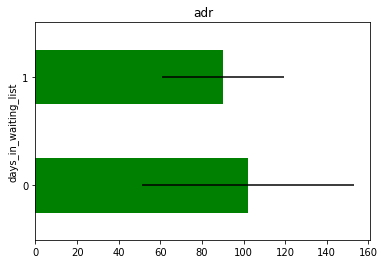

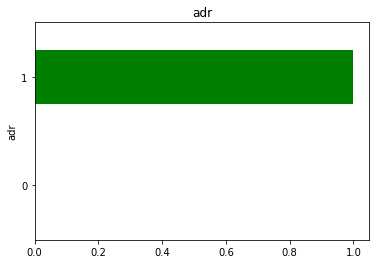

In [351]:
for var in sesgadas:
    temp = data.copy()
    # Colocar las variables en función de 0's y 1's
    temp[var] = np.where(data[var] == 0, 0, 1) # Si el valor es igual a 0, le ponemos 0 y sino le ponemos 1
    
    #Sacar la media y desviación
    temp = temp.groupby(var)['adr'].agg(['mean', 'std'])
    
    #Graficar
    temp.plot(kind='barh', y="mean", legend=False, xerr="std", title = "adr", color="green")
    plt.show()

## 2.7 Variables Categóricas

In [352]:
len(cat_vars) #Cantidad de variables categóricas

14

In [353]:
data[cat_vars].head()

,hotel,is_canceled,arrival_date_month,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
0,Resort Hotel,0,July,BB,PRT,Direct,Direct,0,C,C,No Deposit,Transient,Check-Out,2015-07-01
1,Resort Hotel,0,July,BB,PRT,Direct,Direct,0,C,C,No Deposit,Transient,Check-Out,2015-07-01
2,Resort Hotel,0,July,BB,GBR,Direct,Direct,0,A,C,No Deposit,Transient,Check-Out,2015-07-02
3,Resort Hotel,0,July,BB,GBR,Corporate,Corporate,0,A,A,No Deposit,Transient,Check-Out,2015-07-02
4,Resort Hotel,0,July,BB,GBR,Online TA,TA/TO,0,A,A,No Deposit,Transient,Check-Out,2015-07-03


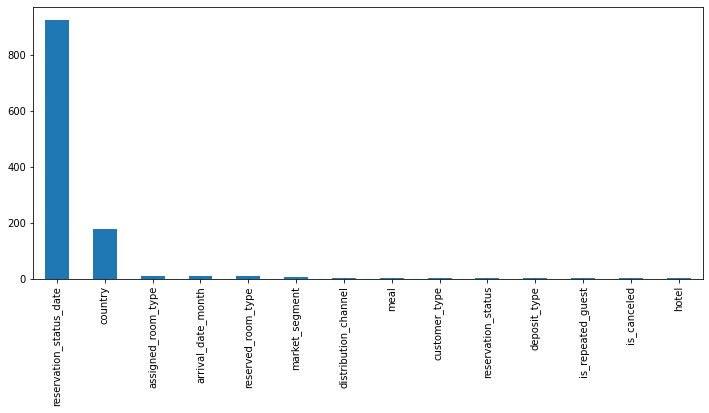

In [354]:
#Sacar la cantidad de valores distintos en cada variable
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [355]:
#Nombres de los valores únicos por cada variable.
#np.unique(data['Embarked'])

In [356]:
np.unique(data['assigned_room_type'])

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'P'],
      dtype=object)

In [357]:
np.unique(data['arrival_date_month'])

array(['April', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September'],
      dtype=object)

In [358]:
np.unique(data['market_segment'])

array(['Aviation', 'Complementary', 'Corporate', 'Direct', 'Groups',
       'Offline TA/TO', 'Online TA', 'Undefined'], dtype=object)

In [359]:
np.unique(data['distribution_channel'])

array(['Corporate', 'Direct', 'GDS', 'TA/TO', 'Undefined'], dtype=object)

In [360]:
np.unique(data['meal'])

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [361]:
np.unique(data['customer_type'])

array(['Contract', 'Group', 'Transient', 'Transient-Party'], dtype=object)

In [362]:
np.unique(data['reservation_status'])

array(['Canceled', 'Check-Out', 'No-Show'], dtype=object)

In [363]:
np.unique(data['hotel'])

array(['City Hotel', 'Resort Hotel'], dtype=object)

In [364]:
np.unique(data['deposit_type'])

array(['No Deposit', 'Non Refund', 'Refundable'], dtype=object)

In [365]:
np.unique(data['is_repeated_guest'])

array([0, 1], dtype=object)

In [366]:
np.unique(data['is_canceled'])

array([0, 1], dtype=object)

In [367]:
#Hacer una codificación ordinal con los valores (un diccionario)
Diccio_ADM = {'April':1, 'August':2, 'December':3, 'February':4, 'January':5, 'July':6, 'June':7, 'March':8, 'May':9,'November':10, 'October':11, 'September':12, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_ART = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'I':9,'K':10, 'L':11, 'P':12, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_MS = {'Aviation':1, 'Complementary':2, 'Corporate':3, 'Direct':4, 'Groups':5, 'Offline TA/TO':6, 'Online TA':7, 'Undefined':8, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_DC = {'Corporate':1, 'Direct':2, 'GDS':3, 'TA/TO':4, 'Undefined':5, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_Meal = {'BB':1, 'FB':2, 'SC':3, 'Undefined':4, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_CT = {'Contract':1, 'Group':2, 'Trascient':3, 'Trascient-Party':4, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_RS = {'Canceled':1, 'Check-Out':2, 'No-Show':3, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_DT = {'No Deposit':1, 'Non Refund':2, 'Refundable':3, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_IRG = {'0':1, '1':2, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_IC = {'0':1, '1':2, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_IC = {'0':1, '1':2, 'Missing':0, 'NA':0, 'NaN':0}
Diccio_Hotel = {'City Hotel':1, 'resort Hotel':2, 'Missing':0, 'NA':0, 'NaN':0}

In [370]:
data['assigned_room_type'] = data['assigned_room_type'].map(Diccio_ART)
data['arrival_date_month'] = data['arrival_date_month'].map(Diccio_ADM)
data['market_segment'] = data['market_segment'].map(Diccio_MS)
data['distribution_channel'] = data['distribution_channel'].map(Diccio_DC)
data['meal'] = data['meal'].map(Diccio_Meal)
data['customer_type'] = data['customer_type'].map(Diccio_CT)
data['reservation_status'] = data['reservation_status'].map(Diccio_RS)
data['hotel'] = data['hotel'].map(Diccio_Hotel)
data['deposit_type'] = data['deposit_type'].map(Diccio_DT)
data['is_repeated_guest'] = data['is_repeated_guest'].map(Diccio_IRG)
data['is_canceled'] = data['is_canceled'].map(Diccio_IC)